# Autoregressive Model Testing

## Notes for revision:
- Use ADF to determine if the data is stationary
- If the data is not stationary, use ACF， PACF to determine the difference
- AR(order, difference, moving average), start with order 1
- Issue: negative R^2 meaning the model is not converging

RMSE reduced by: 
- 13.19% by adding Bitcoin volitility in GDP AR prediction
- 10.86% by adding USD Coin volitility in GDP AR prediction


In [36]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import itertools
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from IPython.display import display, HTML

In [37]:
# Load data
df = pd.read_excel('data/Monthly Mastersheet.xlsx')
print(df.head())

# Ensure date is datetime and set index
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)
df.index = pd.date_range(start=df.index[0], periods=len(df), freq='MS')
df.columns = df.columns.str.strip()

       Month  Bitcoin  Tether  Litecoin     XRP  Ethereum  Dogecoin  Cardano  \
0 2017-09-01  -1.3989 -3.8283   -1.0285 -0.8986   -1.3209   -1.4050      NaN   
1 2017-10-01  -1.3395 -3.7386   -0.7715 -1.1455   -0.8380   -0.4649      NaN   
2 2017-11-01  -1.6230 -4.0195   -1.4483 -1.1921   -1.8379   -1.3711      NaN   
3 2017-12-01  -1.2677 -2.5569   -1.1158 -1.2546   -1.3104   -0.7021      NaN   
4 2018-01-01  -0.8925 -2.7519   -0.2416  0.0390   -0.8113   -0.3344      NaN   

   USD Coin     VIX  ...      CPI      r        M1    GDP        IM        EX  \
0       NaN 10.5900  ... 246.8190 1.1500 3535.6000  60099 2916.0220 2535.5010   
1       NaN  9.5100  ... 246.6630 1.1500 3615.0000  60674 3034.0040 2479.1070   
2       NaN 10.1800  ... 246.6690 1.1600 3587.6000  60674 3034.0040 2479.1070   
3       NaN 11.2800  ... 246.5240 1.3000 3630.5000  60674 3034.0040 2479.1070   
4       NaN 11.0400  ... 247.8670 1.4100 3673.4000  61093 3093.2990 2517.2680   

        CC  CC Monthly % Change 

## Testing all combinations

In [38]:
macro_list = ['LFPR', 'CPI', 'r', 'M1', 'GDP Monthly', 'IM', 'EX', 'CC', 'CC Monthly % Change']
asset_list= ['Bitcoin', 'Tether', 'Litecoin', 'XRP', 'Ethereum', 'Dogecoin', 'Cardano', 'USD Coin','Bitcoin Price']
order = 1
train_end = '2023-05-01'

results_list = []

In [39]:
# Pre-difference all macro variables
for macro in macro_list:
    adf_p = adfuller(df[macro].dropna())[1]
    if adf_p > 0.05:
        df[f'{macro}_diff'] = df[macro].diff()
        adf_p = adfuller(df[f'{macro}_diff'].dropna())[1]
        if adf_p > 0.05:
            df[f'{macro}_diff_diff'] = df[f'{macro}_diff'].diff()

In [40]:
def check_stationarity(series):
    result = adfuller(series.dropna())
    p_value = result[1]
    print(f"ADF test for {series.name}: p-value = {p_value:.4f}")
    return p_value

list = ['Tether', 'XRP', 'Ethereum', 'Cardano', 'MOVE', 'LFPR', 'CPI', 'r', 'M1', 'GDP Monthly', 'IM', 'EX', 'CC','Bitcoin Price']
for l in list:
    check_stationarity(df[l])  # Expect p < 0.05

ADF test for Tether: p-value = 0.8239
ADF test for XRP: p-value = 0.1568
ADF test for Ethereum: p-value = 0.1948
ADF test for Cardano: p-value = 0.3655
ADF test for MOVE: p-value = 0.3994
ADF test for LFPR: p-value = 0.0823
ADF test for CPI: p-value = 0.9045
ADF test for r: p-value = 0.2222
ADF test for M1: p-value = 0.6682
ADF test for GDP Monthly: p-value = 0.8648
ADF test for IM: p-value = 0.9432
ADF test for EX: p-value = 0.8692
ADF test for CC: p-value = 0.6283
ADF test for Bitcoin Price: p-value = 0.9721


In [41]:
# ACF and PACF
def acf(series, name = 'variable'):
    fig, ax = plt.subplots(2, 1, figsize=(10, 6))
    plot_acf(series, lags=30, ax=ax[0])
    ax[0].set_title(f'ACF of {name}')
    plot_pacf(series, lags=30, ax=ax[1])
    ax[1].set_title(f'PACF of {name}')
    plt.tight_layout()
    plt.show()

In [42]:
# Difference the data
def diff(df, col):
    df[col + '_diff'] = df[col].diff()
    return df[col + '_diff'].dropna()

In [43]:
# check_stationarity(df['LFPR'])
# series = df['LFPR'].dropna()
# acf(series, 'LFPR')
# diff(df, 'LFPR')
# series = df['LFPR_diff'].dropna()
# acf(series, 'LFPR_diff')
# check_stationarity(df['LFPR_diff'])

In [44]:
def run_model(df, macro, asset):
    available_cols = df.columns
    if f'{macro}_diff_diff' in available_cols:
        target_col = f'{macro}_diff_diff'
    elif f'{macro}_diff' in available_cols:
        target_col = f'{macro}_diff'
    else:
        target_col = macro

    df_temp = df[[target_col, asset]].dropna().copy()
    target = df_temp[target_col]
    exog = df_temp[[asset]]

    # Train/test split
    train_endog = target[:train_end]
    test_endog = target[train_end:]
    train_exog = exog[:train_end]
    test_exog = exog[train_end:]

    # AR model
    ar_model = SARIMAX(train_endog, order=(order, 0, 0), enforce_stationarity=False, enforce_invertibility=False)
    ar_result = ar_model.fit(disp=False)
    forecast_ar = ar_result.get_forecast(steps=len(test_endog))
    pred_ar = forecast_ar.predicted_mean

    # ARX model
    arx_model = SARIMAX(train_endog, exog=train_exog, order=(order, 0, 0), enforce_stationarity=False, enforce_invertibility=False)
    arx_result = arx_model.fit(disp=False)
    forecast_arx = arx_result.get_forecast(steps=len(test_endog), exog=test_exog)
    pred_arx = forecast_arx.predicted_mean

    # Metrics
    metrics = [
        {
            'Model': 'AR',
            'Macro': macro,
            'Asset': asset,
            'MAE': mean_absolute_error(test_endog, pred_ar),
            'RMSE': np.sqrt(mean_squared_error(test_endog, pred_ar)),
            'R2': r2_score(test_endog, pred_ar)
        },
        {
            'Model': 'ARX',
            'Macro': macro,
            'Asset': asset,
            'MAE': mean_absolute_error(test_endog, pred_arx),
            'RMSE': np.sqrt(mean_squared_error(test_endog, pred_arx)),
            'R2': r2_score(test_endog, pred_arx)
        }
    ]

    return metrics

In [45]:
# Run through all combinations
for macro in macro_list:
    for asset in asset_list:
        try:
            result_metrics = run_model(df.copy(), macro, asset)
            results_list.extend(result_metrics)
        except Exception as e:
            print(f"Error with {macro}-{asset}: {e}")
            continue

# Final table
results_df = pd.DataFrame(results_list)
pd.set_option('display.float_format', lambda x: f'{x:.4f}')
display(HTML(results_df.to_html(max_rows=1000, max_cols=10, notebook=True, escape=False)))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.wa

,Model,Macro,Asset,MAE,RMSE,R2
0,AR,LFPR,Bitcoin,0.0667,0.1069,0.0000
1,ARX,LFPR,Bitcoin,0.0720,0.1075,-0.0119
2,AR,LFPR,Tether,0.0667,0.1069,0.0000
3,ARX,LFPR,Tether,0.0722,0.1077,-0.0151
4,AR,LFPR,Litecoin,0.0667,0.1069,0.0000
5,ARX,LFPR,Litecoin,0.0779,0.1110,-0.0785
6,AR,LFPR,XRP,0.0667,0.1069,0.0000
7,ARX,LFPR,XRP,0.0751,0.1095,-0.0491
8,AR,LFPR,Ethereum,0.0667,0.1069,0.0000
9,ARX,LFPR,Ethereum,0.0770,0.1093,-0.0447


# Combinations Where Adding Asset Data Improves the Model

In [46]:
# Assuming you already have this DataFrame from earlier:
# results_df columns: ['Model', 'Macro', 'Asset', 'MAE', 'RMSE', 'R2']

# Reshape for comparison
df_wide = results_df.pivot_table(
    index=['Macro', 'Asset'],
    columns='Model',
    values=['MAE', 'RMSE', 'R2']
)

df_wide.columns = ['_'.join(col).strip() for col in df_wide.columns.values]
df_wide.reset_index(inplace=True)

# Define better = lower RMSE, lower MAE, higher R²
df_wide['ARX_better_RMSE'] = df_wide['RMSE_ARX'] < df_wide['RMSE_AR']
df_wide['ARX_better_MAE'] = df_wide['MAE_ARX'] < df_wide['MAE_AR']
df_wide['ARX_better_R2']  = df_wide['R2_ARX']  > df_wide['R2_AR']

# Filter: only combinations where ARX is better by **all** metrics
better_all = df_wide[
    (df_wide['ARX_better_RMSE']) &
    (df_wide['ARX_better_MAE']) &
    (df_wide['ARX_better_R2'])
]

# Display results
if not better_all.empty:
    print("Combinations where ARX (with asset) outperforms AR on all metrics:")
    display(better_all[['Macro', 'Asset', 'MAE_AR', 'MAE_ARX', 'RMSE_AR', 'RMSE_ARX', 'R2_AR', 'R2_ARX']])
else:
    print("No combination found where ARX beats AR across MAE, RMSE, and R².")

# If you're interested in partial wins (e.g. just RMSE or R²), you can display those too:
print("Combinations where ARX has lower MAE:")
display(df_wide[df_wide['ARX_better_MAE']][['Macro', 'Asset', 'MAE_AR', 'MAE_ARX', 'R2_AR', 'R2_ARX']])


Combinations where ARX (with asset) outperforms AR on all metrics:


,Macro,Asset,MAE_AR,MAE_ARX,RMSE_AR,RMSE_ARX,R2_AR,R2_ARX
19,CPI,Bitcoin Price,0.5841,0.5840,0.7741,0.7699,-0.0155,-0.0046
20,CPI,Cardano,0.5839,0.5814,0.7739,0.7723,-0.0150,-0.0108
26,CPI,XRP,0.5841,0.5821,0.7741,0.7732,-0.0155,-0.0132
36,GDP Monthly,Bitcoin,83.2059,71.7080,105.2447,93.1866,-0.2861,-0.0083
38,GDP Monthly,Cardano,83.2194,74.6290,105.2545,95.4370,-0.2863,-0.0575
39,GDP Monthly,Dogecoin,83.2059,74.5011,105.2447,94.6529,-0.2861,-0.0402
40,GDP Monthly,Ethereum,83.2059,75.0036,105.2447,102.3413,-0.2861,-0.2161
41,GDP Monthly,Litecoin,83.2059,73.2313,105.2447,98.6190,-0.2861,-0.1292
42,GDP Monthly,Tether,83.2059,71.4243,105.2447,92.9064,-0.2861,-0.0022
43,GDP Monthly,USD Coin,83.2130,71.3234,105.2499,93.3634,-0.2862,-0.0121


Combinations where ARX has lower MAE:


,Macro,Asset,MAE_AR,MAE_ARX,R2_AR,R2_ARX
0,CC,Bitcoin,3.4489,3.4039,-0.0037,-0.0502
2,CC,Cardano,3.4477,3.3777,-0.0032,-0.0506
3,CC,Dogecoin,3.4489,3.4126,-0.0037,-0.0513
4,CC,Ethereum,3.4489,3.3942,-0.0037,-0.0534
5,CC,Litecoin,3.4489,3.4182,-0.0037,-0.0681
6,CC,Tether,3.4489,3.4139,-0.0037,-0.0790
7,CC,USD Coin,3.4455,3.4064,-0.0022,-0.0451
8,CC,XRP,3.4489,3.4308,-0.0037,-0.0629
9,CC Monthly % Change,Bitcoin,0.0521,0.0519,-0.0124,-0.0415
10,CC Monthly % Change,Bitcoin Price,0.0521,0.0510,-0.0124,-0.0411


## Plotting Individual Conbination

In [47]:
macro = 'GDP Monthly'
asset = 'Bitcoin Price'

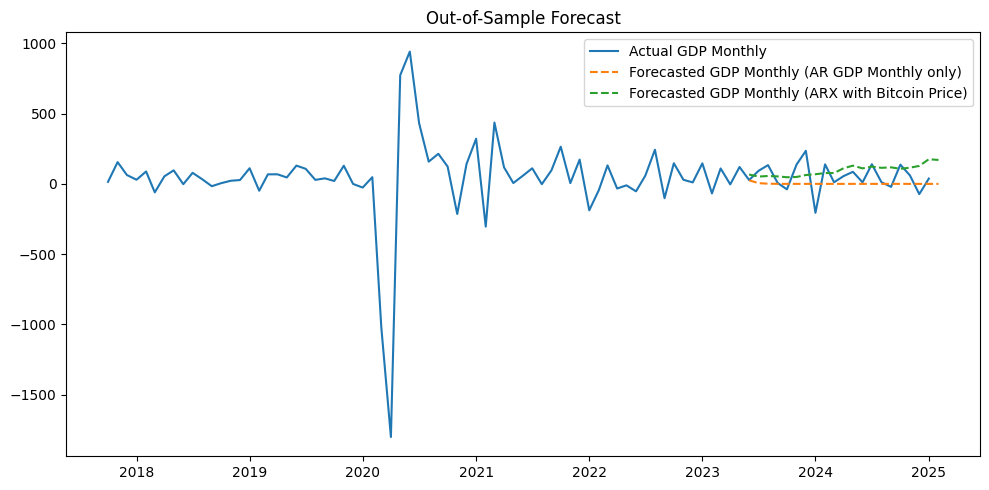

                               SARIMAX Results                                
Dep. Variable:       GDP Monthly_diff   No. Observations:                   68
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -480.553
Date:                Tue, 17 Jun 2025   AIC                            965.107
Time:                        10:41:42   BIC                            969.516
Sample:                    10-01-2017   HQIC                           966.851
                         - 05-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2117      0.037      5.683      0.000       0.139       0.285
sigma2      9.941e+04   6705.413     14.825      0.000    8.63e+04    1.13e+05
Ljung-Box (L1) (Q):                   0.25   Jarque-

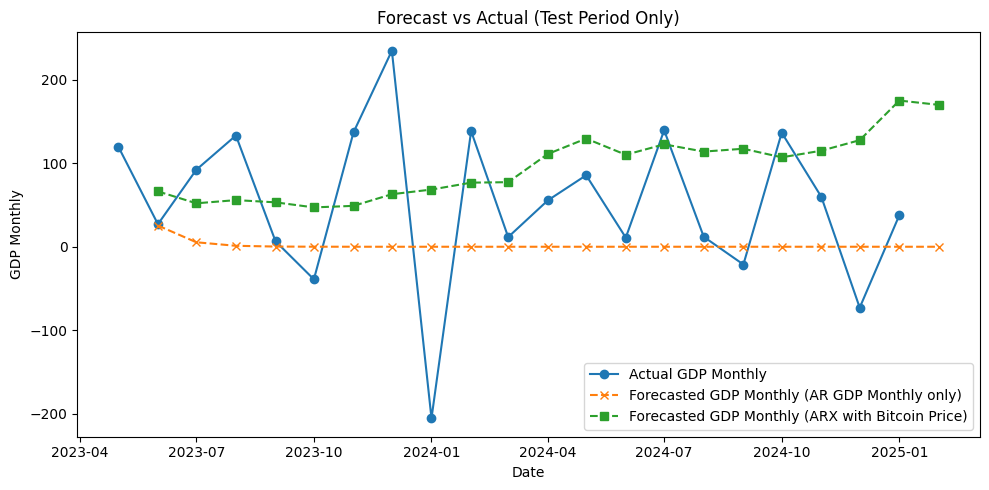

In [ ]:
available_cols = df.columns
if f'{macro}_diff_diff' in available_cols:
    target_col = f'{macro}_diff_diff'
elif f'{macro}_diff' in available_cols:
    target_col = f'{macro}_diff'
else:
    target_col = macro

df_temp = df[[target_col, asset]].dropna().copy()
target = df_temp[target_col]
exog = df_temp[[asset]]

# Train/test split
train_endog = target[:train_end]
test_endog = target[train_end:]
train_exog = exog[:train_end]
test_exog = exog[train_end:]

# AR model
ar_model = SARIMAX(train_endog, order=(order, 0, 0), enforce_stationarity=False, enforce_invertibility=False)
ar_result = ar_model.fit(disp=False)
forecast_ar = ar_result.get_forecast(steps=len(test_endog))
pred_ar = forecast_ar.predicted_mean

# ARX model
arx_model = SARIMAX(train_endog, exog=train_exog, order=(order, 0, 0), enforce_stationarity=False, enforce_invertibility=False)
arx_result = arx_model.fit(disp=False)
forecast_arx = arx_result.get_forecast(steps=len(test_endog), exog=test_exog)
pred_arx = forecast_arx.predicted_mean

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(target, label='Actual ' + macro)
plt.plot(pred_ar, label='Forecasted ' + macro+ f' (AR {macro} only)', linestyle='--')
plt.plot(pred_arx, label=f'Forecasted {macro} (ARX with {asset})', linestyle='--')
plt.title("Out-of-Sample Forecast")
plt.legend()
plt.tight_layout()
plt.show()


# Printing stats
mae_ar = mean_absolute_error(test_endog, pred_ar)
rmse_ar = np.sqrt(mean_squared_error(test_endog, pred_ar))
r2_ar = r2_score(test_endog, pred_ar)
print(ar_result.summary())
print(arx_result.summary())

mae_arx = mean_absolute_error(test_endog, pred_arx)
rmse_arx = np.sqrt(mean_squared_error(test_endog, pred_arx))
r2_arx = r2_score(test_endog, pred_arx)

print("AR model test set evaluation:")
print(f"  MAE:  {mae_ar:.4f}")
print(f"  RMSE: {rmse_ar:.4f}")
print(f"  R²:   {r2_ar:.4f}\n")

print("ARX model test set evaluation:")
print(f"  MAE:  {mae_arx:.4f}")
print(f"  RMSE: {rmse_arx:.4f}")
print(f"  R²:   {r2_arx:.4f}")

# Plot only test data with forecasts
plt.figure(figsize=(10, 5))
plt.plot(test_endog, label='Actual ' + macro, marker='o')
plt.plot(pred_ar, label='Forecasted ' + macro+ f' (AR {macro} only)', linestyle='--', marker='x')
plt.plot(pred_arx, label=f'Forecasted {macro} (ARX with {asset})', linestyle='--', marker='s')
plt.title("Forecast vs Actual (Test Period Only)")
plt.xlabel("Date")
plt.ylabel(macro)
plt.legend()
plt.tight_layout()
plt.show()